In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from PIL import Image


In [4]:
import os
from PIL import Image
import numpy as np

def load_images_from_folder(folder, label, max_images=1000):
    images = []
    labels = []
    counter = 0  # Initialize counter to keep track of processed images

    for filename in os.listdir(folder):
        if counter >= max_images:  # Check if the limit is reached
            break  # Stop processing more images

        print("filename ", filename)
        print("folder ", folder)
        img = Image.open(os.path.join(folder, filename))
        img = img.convert('RGB')

        img = img.resize((128, 128))  # Resize
        img_array = np.array(img).astype('float32') / 255.  # Normalize
        img_array = img_array.flatten()  # Flatten

        if len(img_array) == 128*128*3:
            images.append(img_array)
            labels.append(label)
        else:
            print(f"Skipping image {filename} due to unexpected size")
            continue  # Skip appending to images and labels if size is unexpected

        counter += 1  # Increment counter

    return images, labels


# Paths to your folders
folders = ['/content/drive/My Drive/APS360 Group/Data preprocessing/CombineOldAndNew/Negative',
           '/content/drive/My Drive/APS360 Group/Data preprocessing/CombineOldAndNew/Neutral',
           '/content/drive/My Drive/APS360 Group/Data preprocessing/CombineOldAndNew/Positive']
labels = ['negative', 'neutral', 'positive']

# Load all images and their labels
all_images = []
all_labels = []
for folder, label in zip(folders, labels):

    images, labels = load_images_from_folder(folder, label)
    all_images.extend(images)
    all_labels.extend(labels)

print('done')


Streaming output truncated to the last 5000 lines.
folder  /content/drive/My Drive/APS360 Group/Data preprocessing/CombineOldAndNew/Negative
filename  3339126991_d7809a7d0c.jpg
folder  /content/drive/My Drive/APS360 Group/Data preprocessing/CombineOldAndNew/Negative
filename  6133822757_0a5280b4dc.jpg
folder  /content/drive/My Drive/APS360 Group/Data preprocessing/CombineOldAndNew/Negative
filename  aug_0_3127.jpeg
folder  /content/drive/My Drive/APS360 Group/Data preprocessing/CombineOldAndNew/Negative
filename  93110989_8a2d95c99a.jpg
folder  /content/drive/My Drive/APS360 Group/Data preprocessing/CombineOldAndNew/Negative
filename  138243748_b3dd356812.jpg
folder  /content/drive/My Drive/APS360 Group/Data preprocessing/CombineOldAndNew/Negative
filename  aug_0_9674.jpeg
folder  /content/drive/My Drive/APS360 Group/Data preprocessing/CombineOldAndNew/Negative
filename  aug_0_7.jpeg
folder  /content/drive/My Drive/APS360 Group/Data preprocessing/CombineOldAndNew/Negative
filename  aug

In [5]:
all_lengths = [len(img) for img in all_images]
if len(set(all_lengths)) > 1:
    print("Found inconsistent image sizes!")
else:
    print("All images have consistent sizes.")

# Convert lists to numpy arrays
X = np.array(all_images)
y = np.array(all_labels)

All images have consistent sizes.


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(n_estimators=200, random_state=42)

In [8]:
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.47      0.38      0.42       217
     neutral       0.57      0.52      0.54       197
    positive       0.46      0.60      0.52       186

    accuracy                           0.49       600
   macro avg       0.50      0.50      0.49       600
weighted avg       0.50      0.49      0.49       600

Accuracy: 0.495


# Parameter hypertuning

In [9]:
from sklearn.model_selection import cross_validate

# Initialize cross validation score DataFrame
depth_lb = 1
depth_ub = 21
cv_scores = pd.Series(index=np.arange(depth_lb, depth_ub), dtype=float)

for max_depth in range(depth_lb, depth_ub):

  # Initialize the model
  rf_cv1_model = RandomForestClassifier(random_state = 0, max_depth = max_depth,
                          n_estimators = 50, max_samples=0.2)

  # Run cross validation to get measure of out-of-sample error
  example_cv_results = cross_validate(rf_cv1_model, X_train, y_train, cv=5)

  # Record the average out-of-sample error
  cv_scores.loc[max_depth] = example_cv_results['test_score'].mean()

print("Completed")

Completed


In [10]:
optimal_max_depth = cv_scores.argmax()
print(optimal_max_depth)

10


In [11]:
from sklearn.model_selection import cross_validate

# Initialize cross validation score DataFrame
n_estimators_list = [300, 350, 400]
cv_scores_n_estimators = pd.Series(index=n_estimators_list, dtype=float)

for n_estimators in range(len(n_estimators_list)):

  # Initialize the model
  rf_cv1_model = RandomForestClassifier(random_state = 0, max_depth = optimal_max_depth, n_estimators = n_estimators_list[n_estimators], max_samples=0.2)

  # Run cross validation to get measure of out-of-sample error
  example_cv_results = cross_validate(rf_cv1_model, X_train, y_train, cv=5)

  # Record the average out-of-sample error
  cv_scores_n_estimators[n_estimators_list[n_estimators]] = example_cv_results['test_score'].mean()

print("Completed")

Completed


In [12]:
optimal_n_estimators = cv_scores_n_estimators.idxmax()
print(cv_scores_n_estimators)
print(optimal_n_estimators)

300    0.505833
350    0.502083
400    0.506667
dtype: float64
400


In [13]:
from sklearn.model_selection import cross_validate

# Initialize cross validation score DataFrame
max_samples_list = [0.3, 0.4, 0.5, 0.6]
cv_scores_max_samples = pd.Series(index=max_samples_list, dtype=float)

for max_samples in range(len(max_samples_list)):

  # Initialize the model
  rf_cv1_model = RandomForestClassifier(random_state = 0, max_depth = optimal_max_depth, n_estimators = int(optimal_n_estimators), max_samples=max_samples_list[max_samples])

  # Run cross validation to get measure of out-of-sample error
  example_cv_results = cross_validate(rf_cv1_model, X_train, y_train, cv=5)

  # Record the average out-of-sample error
  cv_scores_max_samples.loc[max_samples_list[max_samples]] = example_cv_results['test_score'].mean()

print("Completed")

Completed


In [14]:
optimal_max_samples = cv_scores_max_samples.idxmax()
print("cv_scores ", cv_scores_max_samples)
print(optimal_max_samples)

cv_scores  0.3    0.513333
0.4    0.516667
0.5    0.502500
0.6    0.515000
dtype: float64
0.4


In [15]:
print("optimal_max_samples", optimal_max_samples)
print("optimal_n_estimators ", optimal_n_estimators)
print("optimal_max_depth", optimal_max_depth)

optimal_max_samples 0.4
optimal_n_estimators  400
optimal_max_depth 10


In [16]:
rf_model_final = RandomForestClassifier(random_state = 0, max_depth = optimal_max_depth, n_estimators = optimal_n_estimators, max_samples=optimal_max_samples)
rf_model_final.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_samples=0.4, n_estimators=400,
                       random_state=0)

In [17]:
y_pred = rf_model_final.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.48      0.40      0.44       217
     neutral       0.55      0.50      0.52       197
    positive       0.47      0.61      0.53       186

    accuracy                           0.50       600
   macro avg       0.50      0.50      0.50       600
weighted avg       0.50      0.50      0.49       600

Accuracy: 0.49666666666666665


# Confusion matrix

['negative', 'neutral', 'positive']


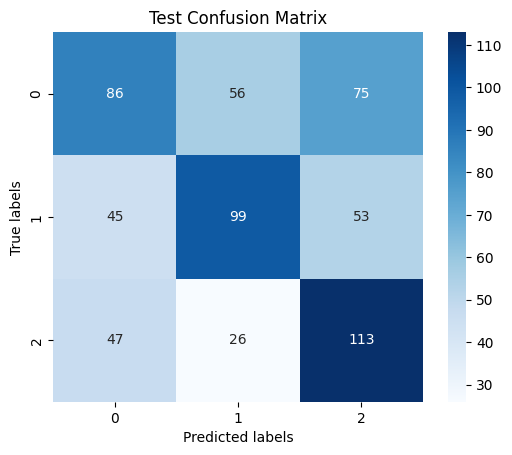

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Making predictions on the test set
y_pred = rf_model_final.predict(X_test)

print(list(rf_model_final.classes_))

# Generating the confusion matrix for the test set predictions
test_conf_matrix = confusion_matrix(y_test, y_pred, labels = ['negative', 'neutral', 'positive'])

# Plotting the confusion matrix

sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', square=True)
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


# Visualizing results

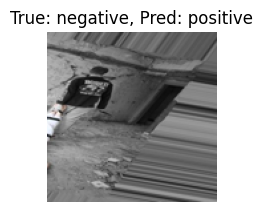

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the exact middle index for X_test
middle_index = len(X_test) // 2

# Select the middle image
indices = [middle_index]  # Select only the middle image
X_selected = X_test[indices]
y_selected = y_test[indices]

# Predicting on the selected sample
# Ensure X_selected is reshaped correctly if needed
y_pred_selected = rf_model_final.predict(X_selected.reshape(1, -1))  # Reshape if your model expects a specific input shape

# Since we have only one image, we simplify the plotting logic
fig, ax = plt.subplots(figsize=(2, 4))

img = X_selected[0].reshape((128, 128, 3))  # Reshape back to the original size
ax.imshow(img)
# Adjusting fontsize for the title to make the text appear smaller
ax.set_title(f"True: {y_selected[0]}, Pred: {y_pred_selected[0]}")
ax.axis('off')

plt.tight_layout()
plt.show()


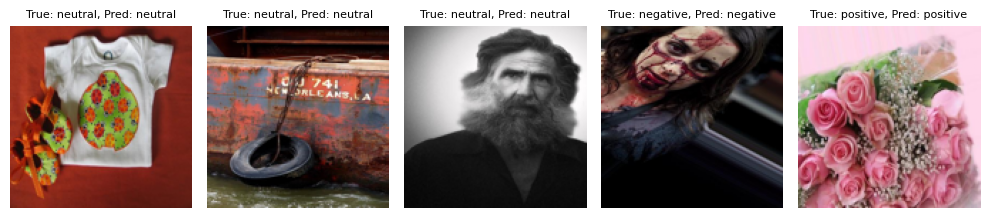

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Selecting 5 images for visualization
indices = np.arange(5)  # Assuming you want the first 5 images for simplicity
X_selected = X_test[indices]
y_selected = y_test[indices]

# Predicting on the selected samples
# Ensure X_selected is reshaped correctly if needed
y_pred_selected = rf_model_final.predict(X_selected.reshape(5, -1))  # Reshape if your model expects a specific input shape

n_selected = len(X_selected)  # Should be 5 as per indices

fig, axes = plt.subplots(1, n_selected, figsize=(n_selected * 2, 4))

for i in range(n_selected):
    ax = axes[i]
    img = X_selected[i].reshape((128, 128, 3))  # Reshape back to the original size
    ax.imshow(img)
    # Adjusting fontsize for the title to make the text appear smaller
    ax.set_title(f"True: {y_selected[i]}, Pred: {y_pred_selected[i]}", fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()


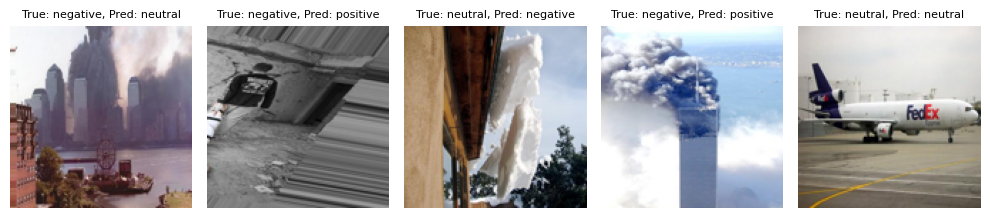

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the middle index of X_test
middle_index = len(X_test) // 2

# Select 5 images from the middle
start_index = middle_index - 1  # Adjust as needed to get 5 images
end_index = middle_index + 4
X_selected = X_test[start_index:end_index]
y_selected = y_test[start_index:end_index]

# Ensure X_selected is correctly reshaped for prediction if needed
y_pred_selected = rf_model_final.predict(X_selected.reshape(5, -1))  # Reshape for prediction

n_selected = len(X_selected)  # This will be 5

fig, axes = plt.subplots(1, n_selected, figsize=(n_selected * 2, 4))

for i in range(n_selected):
    ax = axes[i]
    img = X_selected[i].reshape((128, 128, 3))  # Reshape back to the original size
    ax.imshow(img)
    # Set title with smaller font size
    ax.set_title(f"True: {y_selected[i]}, Pred: {y_pred_selected[i]}", fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()


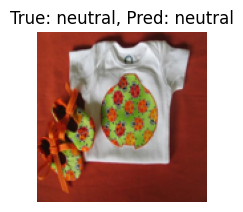

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Selecting a single sample
X_selected = X_test[0:1]  # Use slicing to keep the sample in a 2D array
y_selected = y_test[0]
y_pred_selected = rf_model_final.predict(X_selected)

# Since we're dealing with a single image, no need to check n_selected here
fig, ax = plt.subplots(figsize=(2, 4))

# Reshape back to the original size for visualization
img = X_selected.reshape((128, 128, 3))  # Correctly reshape the single flattened image

ax.imshow(img)  # Display the image
ax.set_title(f"True: {y_selected}, Pred: {y_pred_selected[0]}")  # Display the true and predicted labels
ax.axis('off')  # Hide the axis

plt.tight_layout()
plt.show()
